# Timeseries_02-CreateModel

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It closely follows the [example on the `pastas` website](https://pastas.readthedocs.io/en/latest/examples/001_basic_model.ipynb.html).

## Set up workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer
 - `LWPH4b` = deep alluvial aquifer
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.
We also have data about the river stage (`stage_masl`). This is `NaN` whenever flow in the river ceases.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'LWPH4a', 'LWPH4b', 'LWPH4c']


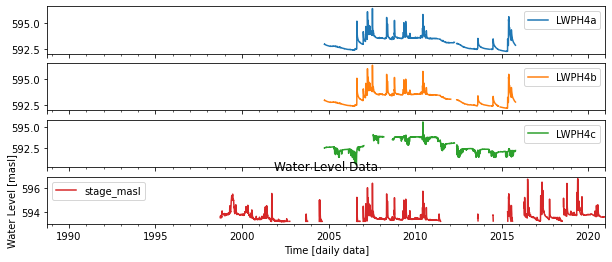

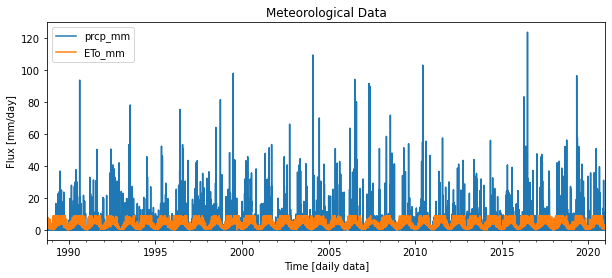

In [2]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4), subplots=True)
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');


## Build simple model

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Time Series LWPH4a: 227 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series ETo_mm: freq=D


Fit report LWPH4a               Fit Statistics
nfev     22                     EVP          42.97
nobs     3807                   R2           0.43
noise    False                  RMSE         0.44
tmin     2004-10-06 00:00:00    AIC           nan
tmax     2015-10-22 00:00:00    BIC           nan
freq     D                      Obj          370.31
warmup   3650 days 00:00:00     ___              
solver   LeastSquares           Interpolated   No

Parameters (4 were optimized)
                optimal  stderr     initial  vary
recharge_A     1.050598  ±5.50%    0.138380  True
recharge_a  1000.000000  ±6.11%   10.000000  True
recharge_f    -1.296736  ±5.71%   -1.000000  True
constant_d   596.136377  ±0.04%  593.137841  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.73
           recharge_f  0.64
recharge_f constant_d -0.82


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=4)'}>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

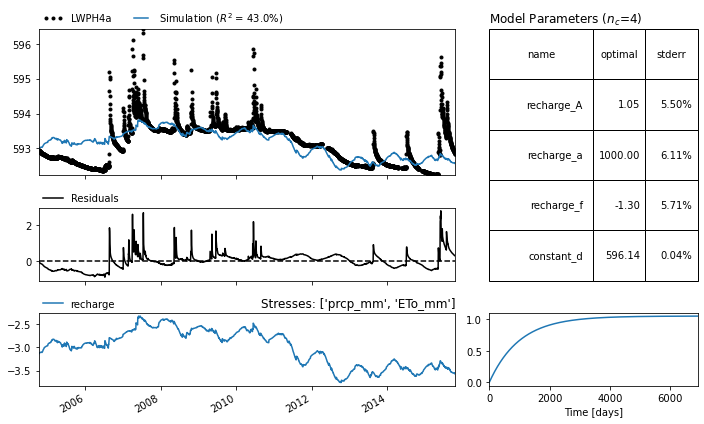

In [3]:
# calculate daily precipitation surplus (P-ETo)
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]

# Create a model object by passing it the observed series
ml_lwph4a = ps.Model(hydrodata["LWPH4a"], name="LWPH4a")

# Add the recharge data as explanatory variable
#sm_precSurplus = ps.StressModel(precSurplus_mm, ps.Gamma, name='PrecSurplus', settings="evap")
#ml_lwph4a.add_stressmodel(sm_precSurplus)

# Add the recharge data as explanatory variable
sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Exponential, name="recharge")
ml_lwph4a.add_stressmodel(sm_rech)

# solve
ml_lwph4a.solve(noise=False)

# plot
ml_lwph4a.plots.results(figsize=(10, 6))

## Add water levels in underlying HPA as an additional stress component
Based on [this example](https://pastas.readthedocs.io/en/latest/examples/004_adding_rivers.ipynb.html), but using HPA levels from well LWPH4c instead of river levels.

INFO: Nan-values were removed at the start of the time series stage_masl.
INFO: Inferred frequency for time series stage_masl: freq=D
INFO: Time Series stage_masl: 3123 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series stage_masl was extended to 1994-10-09 00:00:00 with the mean value of the time series.


Fit report LWPH4a                 Fit Statistics
nfev     33                     EVP           46.73
nobs     3807                   R2             0.47
noise    True                   RMSE           0.43
tmin     2004-10-06 00:00:00    AIC            0.92
tmax     2015-10-22 00:00:00    BIC           44.63
freq     D                      Obj            2.52
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           Interpolated     No

Parameters (7 were optimized)
                optimal    stderr     initial  vary
recharge_A     0.348810  ±312.04%    0.138380  True
recharge_a   999.880226  ±312.75%   10.000000  True
recharge_f    -1.058934   ±68.60%   -1.000000  True
LWPH4c_A       0.907003    ±0.71%    2.518113  True
LWPH4c_a       0.020781    ±0.00%   10.000000  True
constant_d   593.595931    ±0.35%  593.137841  True
noise_alpha  265.296689   ±47.88%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a   1.00
           constant_d  

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=7)'}>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

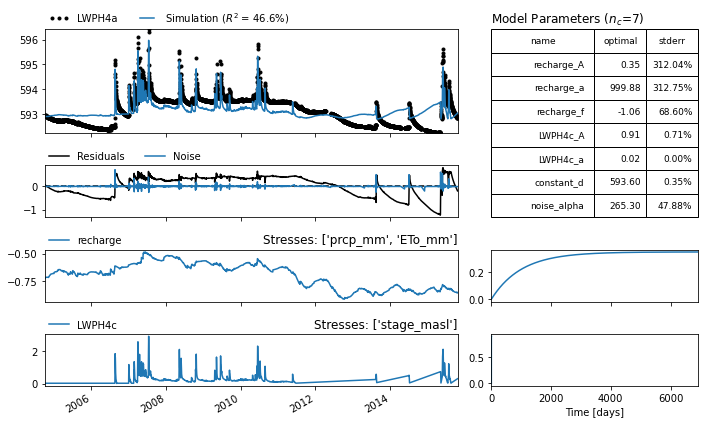

In [4]:
# add water level stress mode
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D")

sm_lwph4c = ps.StressModel(river, rfunc=ps.Exponential, name="LWPH4c",
                           settings="waterlevel")
ml_lwph4a.add_stressmodel(sm_lwph4c)

# solve
ml_lwph4a.solve(noise=True)

# plot
ml_lwph4a.plots.results(figsize=(10, 6))

## Attempts from Raoul

- create models with prec, evap and river stage as explanatory variables
- normalize the river stage by subtracting the minimum, and fill nan's by 0.
- tried ps.One, ps.Exponential and ps.Gamma for both time series
- added tmin to ml.solve, because the systems seems to respond slow..

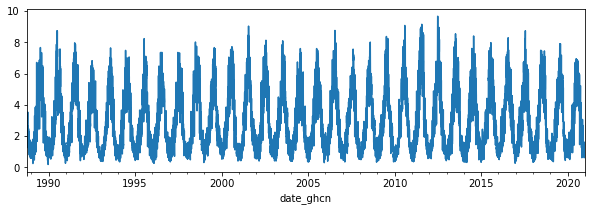

In [5]:
# Try to use a different Evaporation flux
import pyet
lon, lat = 38.27930316507861, -100.3114766523088
et = pyet.hamon(inputdata["tmax_c"].index, (inputdata["tmax_c"] + inputdata["tmin_c"])/2, lat)
et.plot(figsize=(10, 3));

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Time Series LWPH4a: 227 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4a                  Fit Statistics
nfev     25                     EVP            94.03
nobs     2762                   R2              0.94
noise    True                   RMSE            0.14
tmin     2006-01-01 00:00:00    AIC             6.16
tmax     2014-01-01 00:00:00    BIC            47.62
freq     D                      Obj             1.44
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           Interpolated      No

Parameters (7 were optimized)
                 optimal   stderr      initial  vary
recharge_A      7.227041  ±17.47%     7.130573  True
recharge_n      1.253071   ±2.20%     1.217116  True
recharge_a   2428.213219  ±17.77%  2650.526788  True
recharge_f     -0.368530  ±21.92%    -0.377951  True
river_d         0.889206   ±0.58%     1.011236  True
constant_d    588.454952   ±0.17%   588.769594  True
noise_alpha    33.367856  ±13.18%     1.000000  True


INFO: Nan-values were removed at the start of the time series LWPH4b.
INFO: Nan-values were removed at the end of the time series LWPH4b.
INFO: Inferred frequency for time series LWPH4b: freq=D
INFO: Time Series LWPH4b: 310 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4b                  Fit Statistics
nfev     25                     EVP            93.90
nobs     2685                   R2              0.94
noise    True                   RMSE            0.14
tmin     2006-01-01 00:00:00    AIC             6.13
tmax     2014-01-01 00:00:00    BIC            47.39
freq     D                      Obj             1.16
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           Interpolated      No

Parameters (7 were optimized)
                 optimal   stderr      initial  vary
recharge_A      7.051772  ±17.74%     6.944733  True
recharge_n      1.280001   ±2.31%     1.215049  True
recharge_a   2260.597873  ±17.96%  2561.775930  True
recharge_f     -0.362828  ±24.57%    -0.370751  True
river_d         0.839751   ±0.56%     0.991298  True
constant_d    588.357145   ±0.19%   588.680017  True
noise_alpha    41.923501  ±14.83%     1.000000  True


INFO: Nan-values were removed at the start of the time series LWPH4c.
INFO: Nan-values were removed at the end of the time series LWPH4c.
INFO: Inferred frequency for time series LWPH4c: freq=D
INFO: Time Series LWPH4c: 606 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4c                Fit Statistics
nfev     20                     EVP          90.38
nobs     2383                   R2            0.90
noise    True                   RMSE          0.24
tmin     2006-01-01 00:00:00    AIC           6.23
tmax     2014-01-01 00:00:00    BIC          52.44
freq     D                      Obj           9.83
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (8 were optimized)
                optimal   stderr     initial  vary
recharge_A     0.077872  ±20.27%    0.081054  True
recharge_a    37.179666  ±18.19%   18.849991  True
recharge_f    -2.000000  ±15.18%   -2.000000  True
river_A        6.070578   ±6.33%    5.564915  True
river_n        0.624294   ±4.43%    0.814683  True
river_a      706.992382  ±15.96%  445.255029  True
constant_d   592.309066   ±0.01%  592.394755  True
noise_alpha   12.271563   ±9.90%    1.000000  True


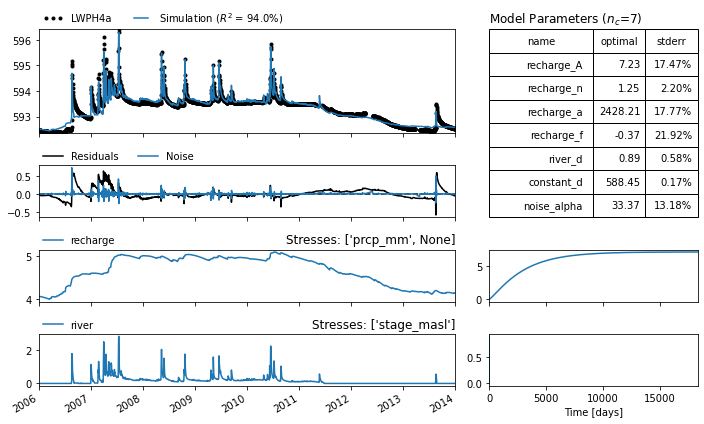

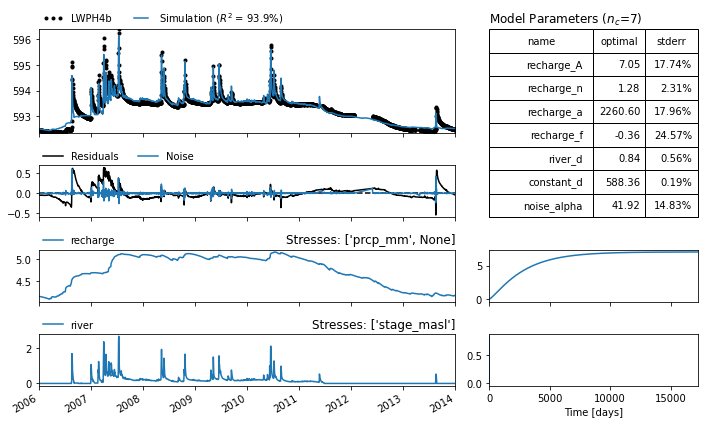

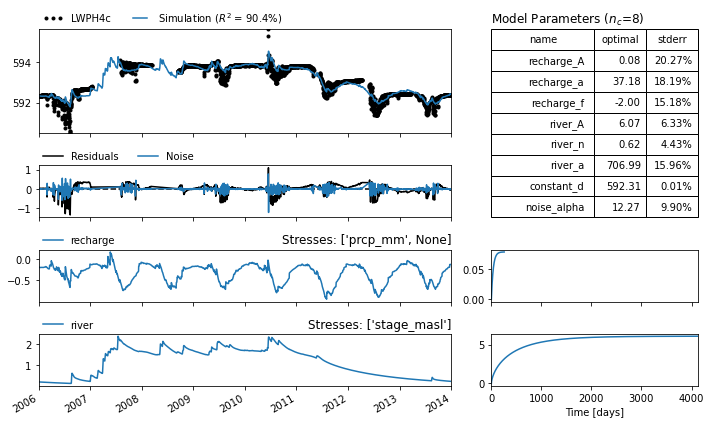

In [13]:
rfunc1 = ps.Gamma
rfunc2 = ps.One
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D").fillna(0)

for name in "LWPH4a", "LWPH4b", "LWPH4c":
    if name =="LWPH4c":
        rfunc2 = ps.Gamma
        rfunc1 = ps.Exponential
        
    ml = ps.Model(hydrodata[name].iloc[::1], name=name)
    sm_rech = ps.RechargeModel(metdata["prcp_mm"], et, #metdata["ETo_mm"], 
                               rfunc=rfunc1, name="recharge")
    ml.add_stressmodel(sm_rech)

    sm_lwph4c = ps.StressModel(river, rfunc=rfunc2, name="river", settings="waterlevel")
    ml.add_stressmodel(sm_lwph4c)
    # solve
    ml.solve(noise=False, report=False, tmin="2006", tmax="2014") # Solve first without noise model to improve initial parameters
    ml.solve(noise=True, initial=False, report="basic", tmin="2006", tmax="2014")

    # plot
    ml.plots.results(figsize=(10, 6))